In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

import os
from sklearn.model_selection import train_test_split

from random import randint

from IPython.display import display, Javascript
import time
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

train_dir = '/content/drive/MyDrive/Colab Notebooks/project2/rps/rps'
test_dir = '/content/drive/MyDrive/Colab Notebooks/project2/rps-test-set/rps-test-set'

classes = os.listdir(train_dir)
print(classes)

X_train_val = []
y_train_val = []
for i, cls in enumerate(os.listdir(train_dir)):
    for img in os.listdir(os.path.join(train_dir, cls)):
        image = cv2.imread(os.path.join(train_dir,cls,img),cv2.IMREAD_GRAYSCALE)
        X_train_val.append(image)
        y_train_val.append(i)
X_test = []
y_test = []
for i, cls in enumerate(os.listdir(test_dir)):
    for img in os.listdir(os.path.join(test_dir, cls)):
        image = cv2.imread(os.path.join(test_dir,cls,img),cv2.IMREAD_GRAYSCALE)
        X_test.append(image)
        y_test.append(i)
X_test = np.array(X_test)
X_train_val = np.array(X_train_val)
y_test = np.array(y_test)
y_train_val = np.array(y_train_val)
X_train_val = X_train_val.reshape(*(X_train_val.shape), 1)
X_test = X_test.reshape(*(X_test.shape), 1)

print(f'There are {X_train_val.shape[0]} samples in training set')
print(f'There are {X_test.shape[0]} samples in test set')

fig, axes = plt.subplots(4,4,figsize=(16,16))
for i in range(16):
    idx = randint(0,X_train_val.shape[0]-1)
    img = X_train_val[idx]
    label = y_train_val[idx]
    axes[i//4][i%4].imshow(img,cmap='gray')
    axes[i//4][i%4].title.set_text(classes[label])

# Preprocess the image data
X_train_val = X_train_val.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# One-hot encode the labels
num_classes = len(classes)
y_train_val = to_categorical(y_train_val, num_classes)
y_test = to_categorical(y_test, num_classes)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, stratify=y_train_val, test_size=0.15)

In [ ]:
# Define the model architecture
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(300,300,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# Define the hyperparameters
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

opt = Adam(learning_rate=lr_schedule)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Define the image data generator for data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

# Fit the model with the training data
batch_size = 32
epochs = 15
earlystop = EarlyStopping(patience=8, restore_best_weights=True,min_delta=1e-3)
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    callbacks=[earlystop])


Epoch 1/15
67/67 [==============================] - 523s 8s/step - loss: 1.0998 - accuracy: 0.3253 - val_loss: 1.1945 - val_accuracy: 0.3316
Epoch 2/15
67/67 [==============================] - 531s 8s/step - loss: 1.0988 - accuracy: 0.3263 - val_loss: 1.1848 - val_accuracy: 0.3316
Epoch 3/15
67/67 [==============================] - 517s 8s/step - loss: 1.0986 - accuracy: 0.3371 - val_loss: 1.1833 - val_accuracy: 0.3316
Epoch 4/15
67/67 [==============================] - 516s 8s/step - loss: 1.0990 - accuracy: 0.3159 - val_loss: 1.1864 - val_accuracy: 0.3316
Epoch 5/15
67/67 [==============================] - 522s 8s/step - loss: 1.0987 - accuracy: 0.3305 - val_loss: 1.1878 - val_accuracy: 0.3316
Epoch 6/15
67/67 [==============================] - 526s 8s/step - loss: 1.0989 - accuracy: 0.3338 - val_loss: 1.1816 - val_accuracy: 0.3316
Epoch 7/15
67/67 [==============================] - 543s 8s/step - loss: 1.0988 - accuracy: 0.3319 - val_loss: 1.1833 - val_accuracy: 0.3316
Epoch 8/15
67

In [ ]:
# test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
# print('Test accuracy:', test_acc)

In [ ]:
model.save('rps_model1.h5')


In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo1.jpg


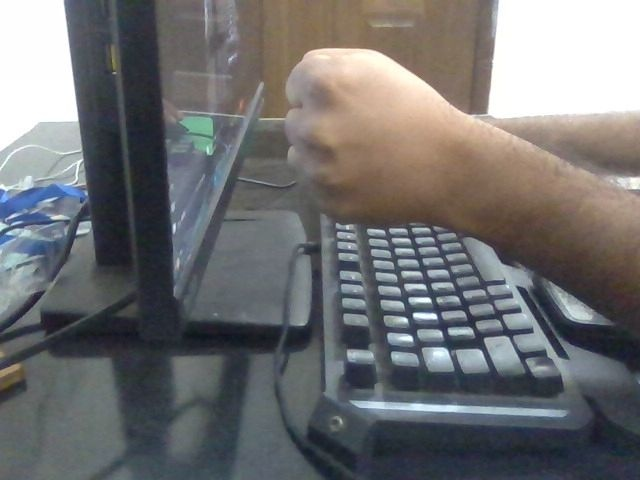

In [ ]:

  filename = take_photo('photo1.jpg')
  print('Saved to {}'.format(filename))

  display(Image(filename))

In [ ]:
import skimage.color as color
from skimage import io

img1 = io.imread('photo.jpg')


1/1 [==============================] - 0s 133ms/step


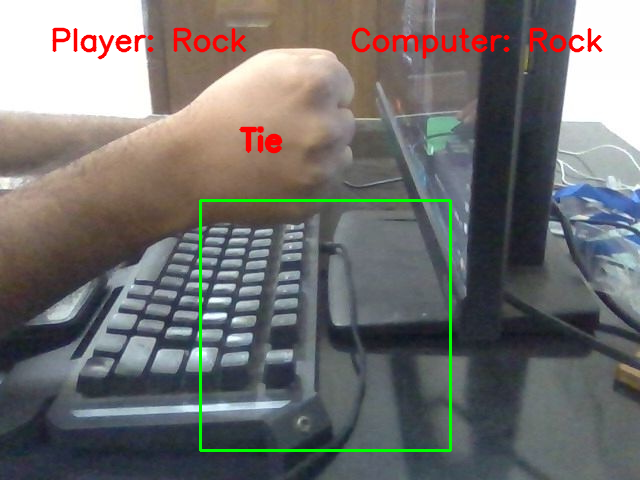

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from google.colab.patches import cv2_imshow
model = tf.keras.models.load_model('/content/rps_model.h5')

def find_winner(player, computer):
    if player == computer:
        return 'Tie'
    elif player == 'Rock' and computer == 'Scissors':
        return 'Win-Player'
    elif player == 'Paper' and computer == 'Rock':
        return 'Win-Player'
    elif player == 'Scissors' and computer == 'Paper':
        return 'Win-Player'
    else:
        return 'Win-Computer'

img = cv2.imread("photo1.jpg")
img = cv2.flip(img, 1)
cv2.rectangle(img, (200, 200), (450, 450), (0, 255, 0), 2)
roi = img[200:450, 200:450]
gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
gray_roi = cv2.resize(gray_roi, (300, 300))
gray_roi = np.array(gray_roi) / 255.0
gray_roi = np.expand_dims(gray_roi, axis=0)
gray_roi = np.expand_dims(gray_roi, axis=-1)
prediction = model.predict(gray_roi)
prediction = np.argmax(prediction)
if prediction == 0:
    gesture = 'Rock'
elif prediction == 1:
    gesture = 'Paper'
else:
    gesture = 'Scissors'
computer_gesture = np.random.choice(['Rock', 'Paper', 'Scissors'])
winner = find_winner(gesture, computer_gesture)
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(img, f'Player: {gesture}', (50, 50), font, 1, (0, 0, 255), 2, cv2.LINE_AA)
cv2.putText(img, f'Computer: {computer_gesture}', (350, 50), font, 1, (0, 0, 255), 2, cv2.LINE_AA)
cv2.putText(img, winner, (240, 150), font, 1, (0, 0, 255), 3, cv2.LINE_AA)
cv2.imwrite("output.jpg", img)
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

